In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [26]:
x_0, x_T = 0, 10
y_0, y_T = 0, 10
T = 1.0
t = np.linspace(0,int(T),int(T*100))
v = np.sqrt((x_T-x_0)**2+(y_T-y_0)**2)/T*(-30*t**2+60*t**3-30*t**4)
a = np.sqrt((x_T-x_0)**2+(y_T-y_0)**2)/T*(-60*t**2+180*t**3-120*t**4)

Text(0, 0.5, 'v')

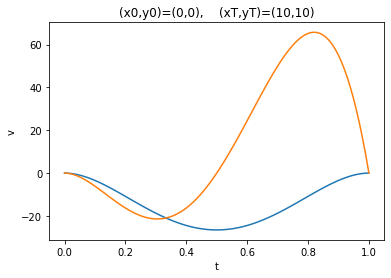

In [27]:
plt.plot(t,v,label='v')
plt.plot(t,a,label='a')
plt.title('(x0,y0)=(0,0),    (xT,yT)=(10,10)')
plt.xlabel('t')
plt.ylabel('v')

In [28]:
x_0, x_T = 4, 5
y_0, y_T = 1, 6
T = 1.0
t = np.linspace(0,int(T),int(T*100))
v = np.sqrt((x_T-x_0)**2+(y_T-y_0)**2)/T*(-30*t**2+60*t**3-30*t**4)
a = np.sqrt((x_T-x_0)**2+(y_T-y_0)**2)/T*(-60*t**2+180*t**3-120*t**4)

Text(0, 0.5, 'v')

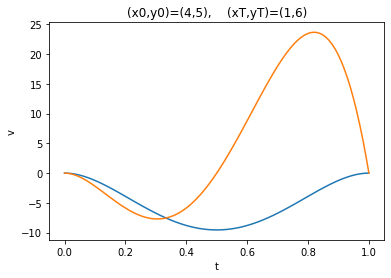

In [29]:
plt.plot(t,v,label='v')
plt.plot(t,a,label='a')
plt.title('(x0,y0)=(4,5),    (xT,yT)=(1,6)')
plt.xlabel('t')
plt.ylabel('v')